In [29]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torchvision.models.detection.rpn import AnchorGenerator
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm


In [30]:
RAW_IMAGE_FOLDER = r"F:\University\F1403\NNDL\Neural-Networks-and-Deep-Learning-Course-Projects-F2024\CA3\FullIJCNN2013"
ANNOTATIONS_FILE = r"F:\University\F1403\NNDL\Neural-Networks-and-Deep-Learning-Course-Projects-F2024\CA3\FullIJCNN2013\gt.txt"

CLASS_TO_CATEGORY = {
    **dict.fromkeys(range(0, 11), "prohibitory"),
    **dict.fromkeys(range(11, 32), "danger"),
    **dict.fromkeys(range(33, 42), "mandatory"),
    **dict.fromkeys([6, 12, 13, 14, 17, 32, 41, 42], "other")
}

CLASS_ID_TO_LABEL = {
    0: "speed limit 20 (prohibitory)",
    1: "speed limit 30 (prohibitory)",
    2: "speed limit 50 (prohibitory)",
    3: "speed limit 60 (prohibitory)",
    4: "speed limit 70 (prohibitory)",
    5: "speed limit 80 (prohibitory)",
    6: "restriction ends 80 (other)",
    7: "speed limit 100 (prohibitory)",
    8: "speed limit 120 (prohibitory)",
    9: "no overtaking (prohibitory)",
    10: "no overtaking (trucks) (prohibitory)",
    11: "priority at next intersection (danger)",
    12: "priority road (other)",
    13: "give way (other)",
    14: "stop (other)",
    15: "no traffic both ways (prohibitory)",
    16: "no trucks (prohibitory)",
    17: "no entry (other)",
    18: "danger (danger)",
    19: "bend left (danger)",
    20: "bend right (danger)",
    21: "bend (danger)",
    22: "uneven road (danger)",
    23: "slippery road (danger)",
    24: "road narrows (danger)",
    25: "construction (danger)",
    26: "traffic signal (danger)",
    27: "pedestrian crossing (danger)",
    28: "school crossing (danger)",
    29: "cycles crossing (danger)",
    30: "snow (danger)",
    31: "animals (danger)",
    32: "restriction ends (other)",
    33: "go right (mandatory)",
    34: "go left (mandatory)",
    35: "go straight (mandatory)",
    36: "go right or straight (mandatory)",
    37: "go left or straight (mandatory)",
    38: "keep right (mandatory)",
    39: "keep left (mandatory)",
    40: "roundabout (mandatory)",
    41: "restriction ends (overtaking) (other)",
    42: "restriction ends (overtaking (trucks)) (other)"
}


In [31]:

class TrafficSignDataset(Dataset):
    def __init__(self, image_folder, annotations_file, transforms=None):
        self.image_folder = image_folder
        self.transforms = transforms

        self.annotations = np.genfromtxt(annotations_file, delimiter=';', dtype=None, encoding='utf-8')

        self.annotation_dict = {}
        for entry in self.annotations:
            img_name = entry[0]
            bbox = [float(entry[1]), float(entry[2]), float(entry[3]), float(entry[4])]
            label = int(entry[5])

            if img_name not in self.annotation_dict:
                self.annotation_dict[img_name] = []
            self.annotation_dict[img_name].append((bbox, label))

        self.img_names = sorted(self.annotation_dict.keys())

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.image_folder, img_name)

        img = Image.open(img_path).convert("RGB")

        # Get bounding boxes and labels for the image
        annotations = self.annotation_dict[img_name]
        boxes = [ann[0] for ann in annotations]
        labels = [ann[1] for ann in annotations]

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Additional target metadata
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms to the image
        if self.transforms:
            img = self.transforms(img)
        else:
            img = torchvision.transforms.ToTensor()(img)  # Ensure tensor conversion

        return img, target


    def __len__(self):
        return len(self.img_names)

In [ ]:

def classify_bbox_sizes_and_classes(dataset):
    size_category_counts = {
        "small": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "medium": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "large": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0}
    }

    for _, target in dataset:
        boxes = target["boxes"]
        labels = target["labels"]

        for box, label in zip(boxes, labels):
            width = box[2] - box[0]
            if width < 32:
                size_group = "small"
            elif 32 <= width <= 45:
                size_group = "medium"
            else:
                size_group = "large"

            major_category = CLASS_TO_CATEGORY.get(label.item(), "other")
            size_category_counts[size_group][major_category] += 1

    return size_category_counts

def visualize_class_distribution(size_category_counts):
    categories = ["prohibitory", "mandatory", "danger", "other"]
    size_groups = ["small", "medium", "large"]
    width = 0.2
    x = np.arange(len(size_groups))

    bar_data = {cat: [size_category_counts[size][cat] for size in size_groups] for cat in categories}

    plt.figure(figsize=(12, 6))
    for i, category in enumerate(categories):
        plt.bar(x + i * width, bar_data[category], width, label=category)

    plt.title("Class Distribution by Size Category")
    plt.xlabel("Size Category")
    plt.ylabel("Frequency")
    plt.xticks(x + width * 1.5, size_groups)
    plt.legend(title="Class Group")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
def visualize_images_with_annotations(dataset, indices):
    """
    Visualize a few images with bounding box annotations from the dataset.

    Args:
        dataset: The dataset containing images and annotations.
        indices: List of indices of images to visualize.
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    num_images = len(indices)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axs = [axs]

    for ax, idx in zip(axs, indices):
        img, target = dataset[idx]

        img_np = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

        if img_np.max() > 1:
            img_np /= 255.0

        ax.imshow(img_np)

        # Draw bounding boxes
        for box, label in zip(target["boxes"].numpy(), target["labels"].numpy()):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Label: {label}", color="white", 
                    bbox=dict(facecolor='red', edgecolor='red', alpha=0.7))

        ax.axis("off")
        ax.set_title(f"Image {idx}")

    plt.tight_layout()
    plt.show()


def split_dataset(dataset, train_ratio=0.8):
    label_counts = Counter()
    for _, target in dataset:
        label_counts.update(target["labels"].tolist())

    train_indices, val_indices = [], []
    train_class_counts, val_class_counts = Counter(), Counter()

    for idx, (_, target) in enumerate(dataset):
        labels = target["labels"].tolist()
        if all(train_class_counts[label] < train_ratio * label_counts[label] for label in labels):
            train_indices.append(idx)
            train_class_counts.update(labels)
        else:
            val_indices.append(idx)
            val_class_counts.update(labels)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    return train_dataset, val_dataset

def plot_class_distribution(dataset, title):
    label_counts = Counter()
    for _, target in dataset:
        label_counts.update(target["labels"].tolist())

    labels, counts = zip(*sorted(label_counts.items()))
    plt.bar(labels, counts, tick_label=[CLASS_ID_TO_LABEL[label] for label in labels], color='blue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Class Labels")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()



In [33]:
transforms = None

dataset = TrafficSignDataset(RAW_IMAGE_FOLDER, ANNOTATIONS_FILE, transforms=transforms)
print(f"Number of images: {len(dataset)}")

Number of images: 741


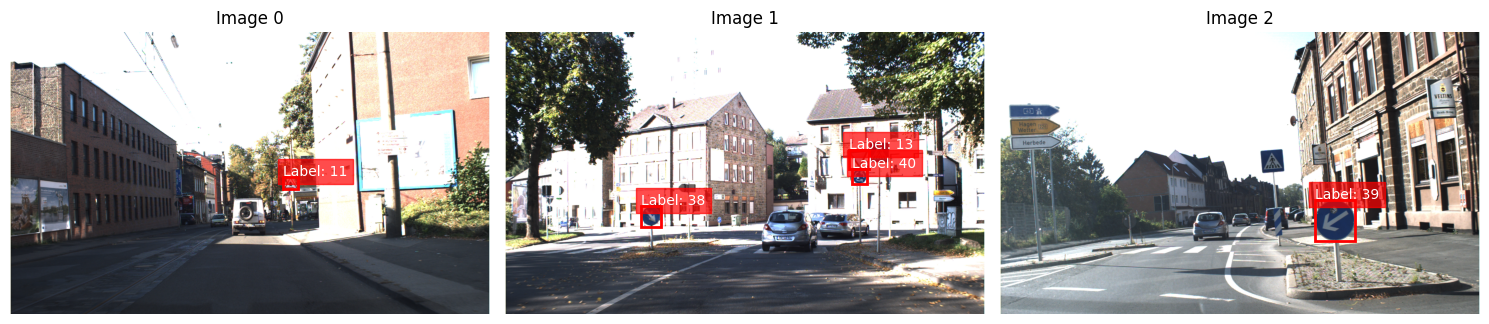

In [34]:
visualize_images_with_annotations(dataset, indices=[0, 1, 2])

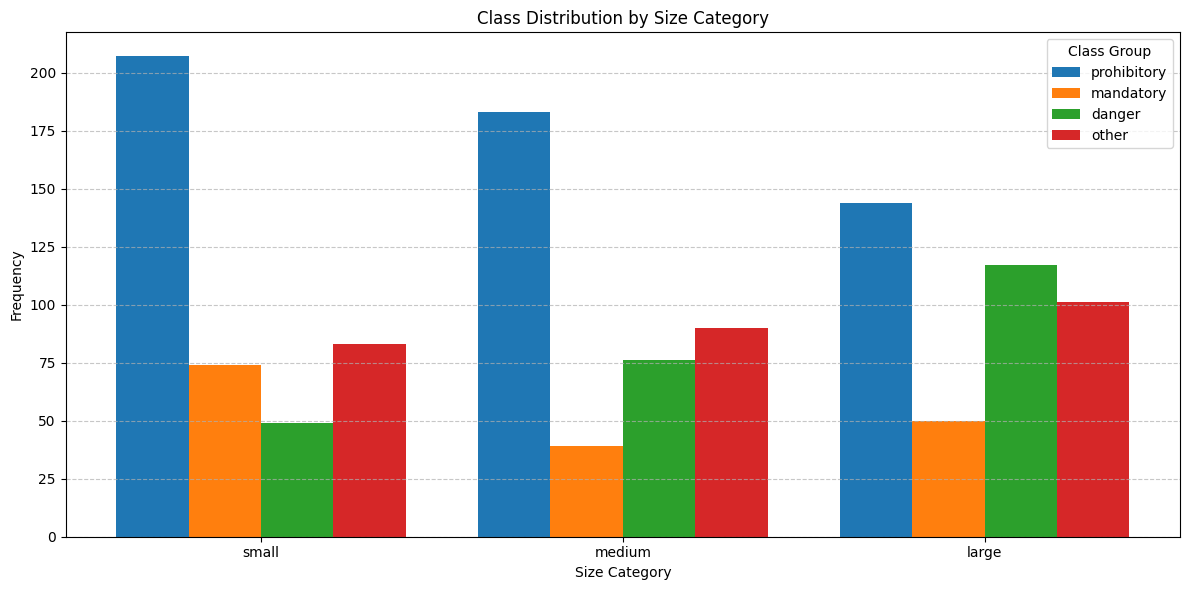

In [35]:
size_category_counts = classify_bbox_sizes_and_classes(dataset)
visualize_class_distribution(size_category_counts)

Total dataset size: 741
Training dataset size: 612
test dataset size: 129


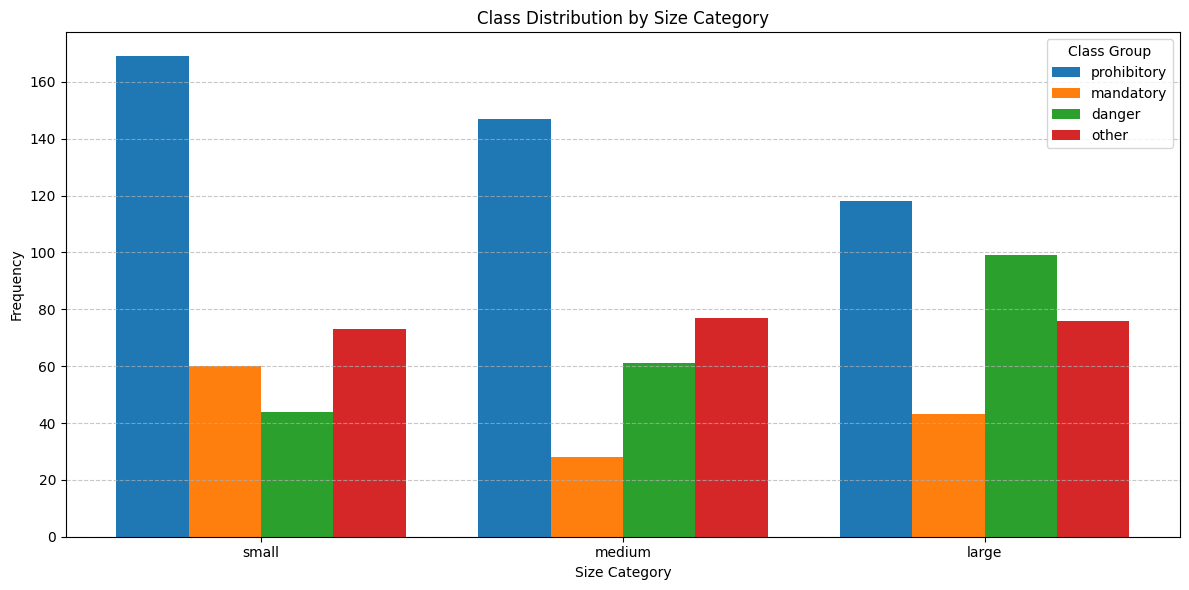

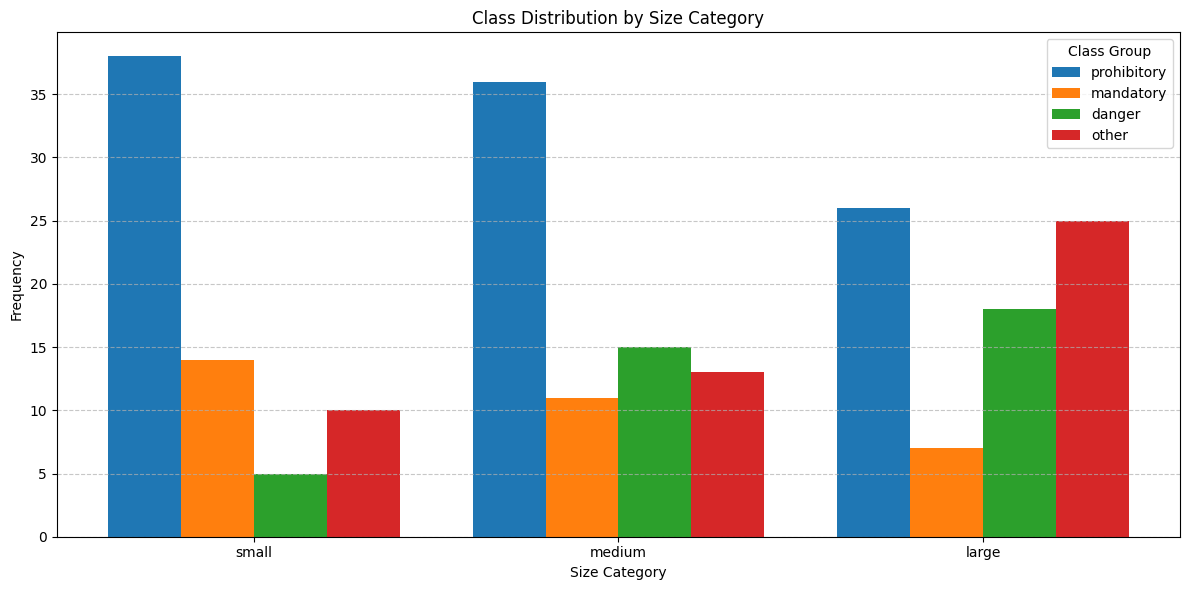

In [36]:
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8)

print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"test dataset size: {len(test_dataset)}")

size_category_counts = classify_bbox_sizes_and_classes(train_dataset)
visualize_class_distribution(size_category_counts)

size_category_counts = classify_bbox_sizes_and_classes(test_dataset)
visualize_class_distribution(size_category_counts)

In [37]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [38]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    loss_history = []

    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_history.append(losses.item())

    return np.mean(loss_history)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea

def evaluate(model, data_loader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_boxes = target["boxes"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()

                for tb, pb in zip(true_boxes, pred_boxes):
                    iou = calculate_iou(tb, pb)
                    iou_scores.append(iou)

    return np.mean(iou_scores)

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 43
model = get_model(num_classes).to(device)
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")

    iou_score = evaluate(model, val_loader, device)
    print(f"Epoch {epoch + 1}, Validation IoU: {iou_score}")

torch.save(model.state_dict(), "fasterrcnn_resnet50.pth")

100%|██████████| 153/153 [02:16<00:00,  1.12it/s]


Epoch 1, Training Loss: 0.5176197675123714
Epoch 1, Validation IoU: 0.4375184334346857


100%|██████████| 153/153 [02:14<00:00,  1.14it/s]


Epoch 2, Training Loss: 0.34862323748130425
Epoch 2, Validation IoU: 0.4332071330258648


100%|██████████| 153/153 [02:20<00:00,  1.09it/s]


Epoch 3, Training Loss: 0.28399528563022614
Epoch 3, Validation IoU: 0.3982135999330908


100%|██████████| 153/153 [02:22<00:00,  1.08it/s]


Epoch 4, Training Loss: 0.24420139042575376
Epoch 4, Validation IoU: 0.42326371867414025


100%|██████████| 153/153 [02:25<00:00,  1.05it/s]


Epoch 5, Training Loss: 0.2102096489831513
Epoch 5, Validation IoU: 0.3703327232602237


100%|██████████| 153/153 [02:27<00:00,  1.04it/s]


Epoch 6, Training Loss: 0.1885235430855377
Epoch 6, Validation IoU: 0.3865214067563606


100%|██████████| 153/153 [02:27<00:00,  1.04it/s]


Epoch 7, Training Loss: 0.16377538074952325
Epoch 7, Validation IoU: 0.41766037653557264


100%|██████████| 153/153 [02:29<00:00,  1.02it/s]


Epoch 8, Training Loss: 0.14339218709885684
Epoch 8, Validation IoU: 0.43158438792237963


100%|██████████| 153/153 [02:24<00:00,  1.06it/s]


Epoch 9, Training Loss: 0.13171973890241453
Epoch 9, Validation IoU: 0.41300929827034316


100%|██████████| 153/153 [02:28<00:00,  1.03it/s]


Epoch 10, Training Loss: 0.1149746909177576
Epoch 10, Validation IoU: 0.3326561247564515
